In [1]:
# how to build a graph nerual network 

import torch_geometric

In [6]:
# nodes -> puplications 
# edges -> citations
# lables -> paper about NN, GNN, etc

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
dataset

Cora()

In [7]:
dataset[0]
# Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# nodes = 2708
# edges = 10556
# features = 1433
# labels = 72708

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [11]:
# Binary Mask

dataset.train_mask.sum().item()

140

In [15]:
dataset.x[4][:50]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
dataset.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [18]:
dataset.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [19]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)


        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        return F.log_softmax(x, dim=1)

In [31]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Example GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(1433, hidden_channels)  # For Cora specifically
        self.conv2 = GCNConv(hidden_channels, 7)     # For Cora specifically

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Load dataset (Cora) and move it to device
dataset = Planetoid(root='data/Planetoid', name='Cora')[0]
device = 'cpu'
dataset = dataset.to(device)

# Model, optimizer, loss
model = GCN(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.x, dataset.edge_index)
    loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(dataset.x, dataset.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]
    test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())
    return test_acc

losses = []
for epoch in range(1, 201):
    loss = train()
    losses.append(loss)
    acc = test()
    if(epoch % 10 == 0):
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')


Epoch: 010, Loss: 0.8432, Test Acc: 0.7690
Epoch: 020, Loss: 0.2004, Test Acc: 0.8070
Epoch: 030, Loss: 0.0479, Test Acc: 0.8070
Epoch: 040, Loss: 0.0206, Test Acc: 0.8090
Epoch: 050, Loss: 0.0155, Test Acc: 0.8030
Epoch: 060, Loss: 0.0159, Test Acc: 0.8060
Epoch: 070, Loss: 0.0174, Test Acc: 0.8100
Epoch: 080, Loss: 0.0182, Test Acc: 0.8110
Epoch: 090, Loss: 0.0180, Test Acc: 0.8120
Epoch: 100, Loss: 0.0170, Test Acc: 0.8100
Epoch: 110, Loss: 0.0160, Test Acc: 0.8140
Epoch: 120, Loss: 0.0150, Test Acc: 0.8120
Epoch: 130, Loss: 0.0142, Test Acc: 0.8140
Epoch: 140, Loss: 0.0135, Test Acc: 0.8120
Epoch: 150, Loss: 0.0129, Test Acc: 0.8120
Epoch: 160, Loss: 0.0124, Test Acc: 0.8110
Epoch: 170, Loss: 0.0119, Test Acc: 0.8120
Epoch: 180, Loss: 0.0115, Test Acc: 0.8130
Epoch: 190, Loss: 0.0111, Test Acc: 0.8130
Epoch: 200, Loss: 0.0108, Test Acc: 0.8120


# ZINC

In [60]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool  # We'll use a simple GCN as an example
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# Set the device to MPS if available, otherwise fall back to CPU
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device="cpu"
print(f"Using device: {device}")


Using device: cpu


In [14]:
# Each graph corresponds to a molecule where nodes (atoms) are connected by edges (bonds).
# The goal is usually to predict some continuous value, such as a molecular property (in many tasks, it’s a logP or a QED property).
# The ZINC dataset consists of 10000 graphs with 9 different continuous node features.

root = '../data/ZINC'  # path to store the data

train_dataset = ZINC(root, split='train', subset=True)
val_dataset = ZINC(root, split='val', subset=True)
test_dataset = ZINC(root, split='test', subset=True)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 11995.00it/s]

Number of training graphs: 10000
Number of validation graphs: 1000
Number of test graphs: 1000



Done!


## 3. Exploratory Data Analysis (EDA)



In [15]:
data_sample = train_dataset[0]
print(data_sample)

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])


In [35]:
data_sample['x'].squeeze().shape

torch.Size([29])

In [38]:
data_sample['y']

tensor([0.8350])

In [40]:
data_sample['edge_index'].t().shape

torch.Size([64, 2])

In [16]:
# data_sample['x'], data_sample['y'], data_sample['edge_index'].t()

In [17]:
import numpy as np

num_nodes = [data.num_nodes for data in train_dataset]
num_edges = [data.num_edges for data in train_dataset]

print(f"Average number of nodes in train set: {np.mean(num_nodes):.2f}")
print(f"Average number of edges in train set: {np.mean(num_edges):.2f}")


Average number of nodes in train set: 23.17
Average number of edges in train set: 49.86


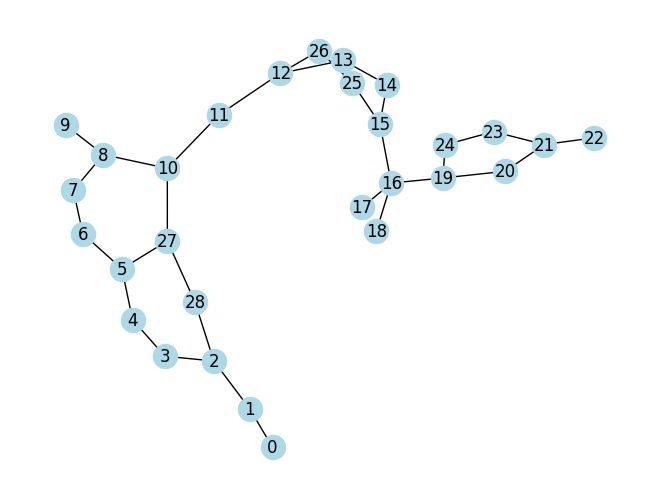

In [41]:
import networkx as nx

def visualize_molecule(data):
    G = nx.Graph()
    edge_index = data.edge_index
    x = data.x

    # Add nodes
    for i in range(data.num_nodes):
        G.add_node(i)
    # Add edges
    num_edges = edge_index.shape[1]
    for i in range(num_edges):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        G.add_edge(src, dst)

    nx.draw(G, with_labels=True, node_color='lightblue')
    plt.show()

visualize_molecule(data_sample)


## 4. Creating a Graph Neural Network



In [45]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        # First graph convolution layer
        self.conv1 = GCNConv(in_channels=dataset_num_features, out_channels=hidden_channels)
        # Second graph convolution layer
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
        
        # Final MLP layers (graph-level readout)
        self.lin1 = nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)  # Predicting a single property

    def forward(self, x, edge_index, batch):
        # Graph Convolution 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Graph Convolution 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global Mean Pooling
        x = global_mean_pool(x, batch)

        # MLP part
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x


In [46]:
dataset_num_features = train_dataset.num_node_features
print(f"Number of node features: {dataset_num_features}")


Number of node features: 1


In [47]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [82]:
from tqdm import tqdm

In [86]:
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch).squeeze(-1)
        # out is now [batch_size], data.y is [batch_size] => no shape mismatch
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x.float(), data.edge_index, data.batch).squeeze(-1)
            loss = criterion(out, data.y.float())
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

num_epochs = 2000
train_losses, val_losses = [], []

for epoch in tqdm(range(1, num_epochs+1), desc="Training", unit="epoch", ):
    train_loss = train()
    val_loss = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Training: 100%|██████████| 2000/2000 [39:17<00:00,  1.18s/epoch] 


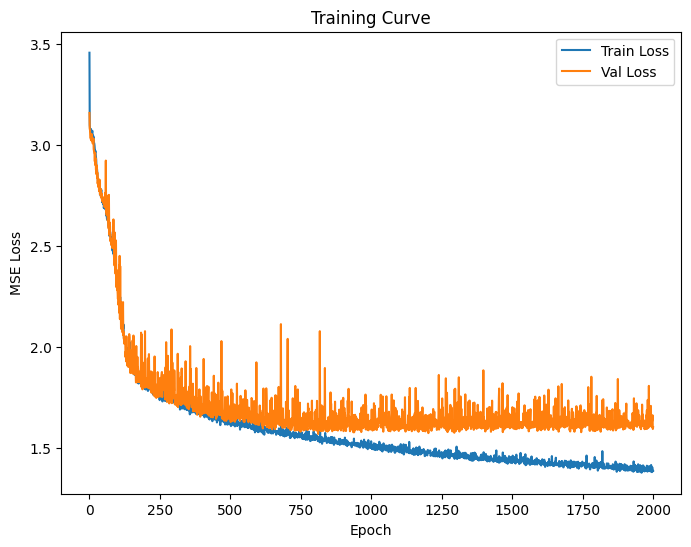

In [87]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Curve')
plt.legend()
plt.show()


In [88]:
test_loss = evaluate(test_loader)
print(f"Test MSE: {test_loss:.4f}")

Test MSE: 1.6278


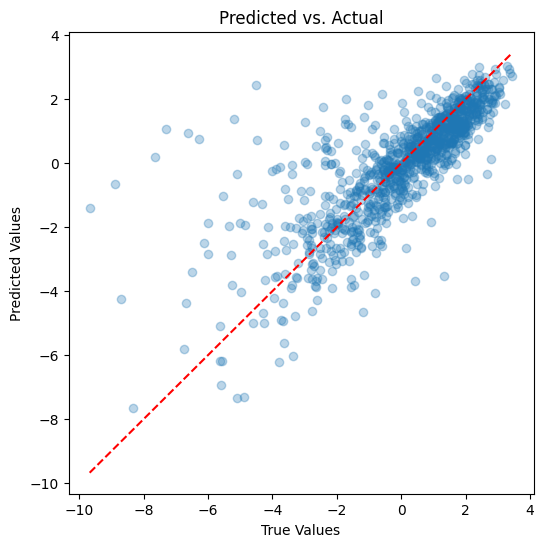

In [89]:
import torch
import matplotlib.pyplot as plt

model.eval()
predictions = []
targets = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        # Model output (shape [batch_size] after squeezing)
        out = model(data.x.float(), data.edge_index, data.batch).squeeze(-1)
        predictions.append(out.cpu())
        targets.append(data.y.cpu())

# Concatenate all predictions and targets from batches
predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

# Convert to NumPy for plotting
predictions_np = predictions.numpy()
targets_np = targets.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(targets_np, predictions_np, alpha=0.3)
plt.plot([targets_np.min(), targets_np.max()],
         [targets_np.min(), targets_np.max()],
         color='red', linestyle='--')  # Diagonal
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual')
plt.show()


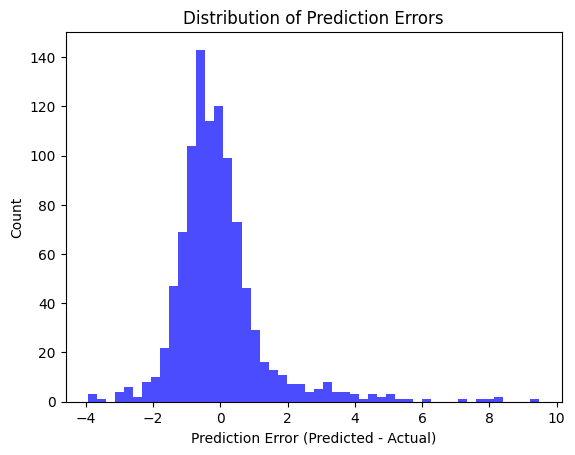

In [75]:
import numpy as np

errors = predictions_np - targets_np
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.show()


In [76]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(targets_np, predictions_np)
r2 = r2_score(targets_np, predictions_np)

print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")


MAE: 0.8882
R^2: 0.5514
